<a href="https://colab.research.google.com/github/Haodong12/AIPI-590/blob/main/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment #3 - Interpretable ML

Haodong He

This assignment used Linear Regression, Logistic Regression and GAM approach to understand the factors contributed to customer churn and type of customer liket to churn.

https://colab.research.google.com/drive/1-RkJwS3PAaXy8jYT_7s78b62gF8W1zDc#scrollTo=QIEdAgHOoJV2

In [1]:
!pip install pandas --quiet


In [35]:
!pip install pygam --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 17.9 MB/s eta 0:00:00


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools import add_constant
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LogisticGAM, s, f

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Path to the CSV file in Google Drive
csv_path = '/content/drive/MyDrive/assignment #03/Telco-Customer-Churn.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
print(df.head())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [6]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


Linear Regression Assumptions:

1. Linearity: The relationship between the predictors and churn is not linear, which violates the linearity assumption. Logistic regression is more suitable for this binary classification problem.

2. Independence of Errors: The Durbin-Watson test result (~2.0) indicates that the residuals are independent, so this assumption is satisfied.

3. Homoscedasticity: The residual plot shows heteroscedasticity (funnel shape), violating this assumption.

4. Multicollinearity: The high VIF values for several features suggest significant multicollinearity, which violates the assumption of no multicollinearity.

5. Normality of Residuals: This assumption is not met since the residuals are not normally distributed, which is expected with a binary target variable.

In [7]:
# Convert the 'Churn' column to numeric
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values
df = df.dropna()

In [8]:
# One-Hot Encoding of Categorical Variables
# Get a list of categorical columns
categorical_features = df.select_dtypes(include=['object']).columns.drop('customerID')

# Apply one-hot encoding to the categorical features
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
# Convert True/False to 0/1
# Ensure all categorical encoded columns are numeric (True/False to 0/1)
df_encoded = df_encoded.drop(columns=['customerID'], errors='ignore')
df_encoded = df_encoded.astype(int)

In [9]:
df_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29,29,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56,1889,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53,108,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42,1840,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70,151,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


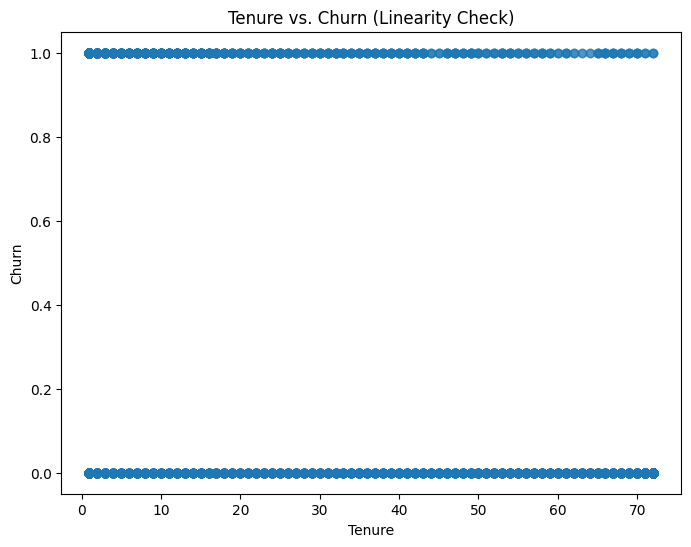

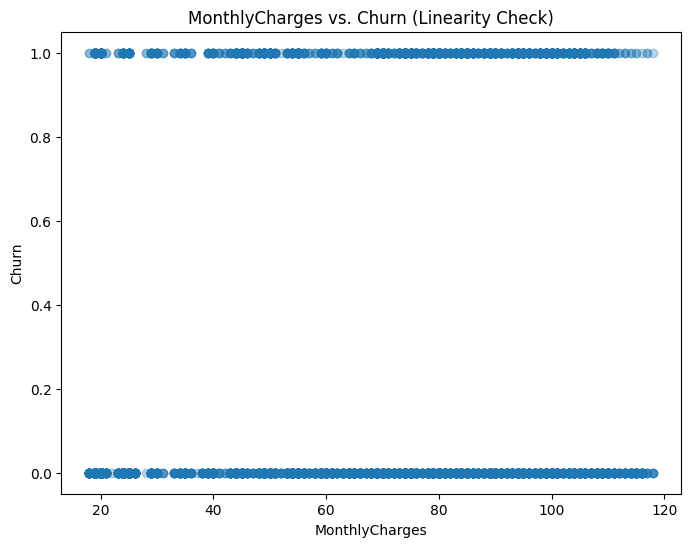

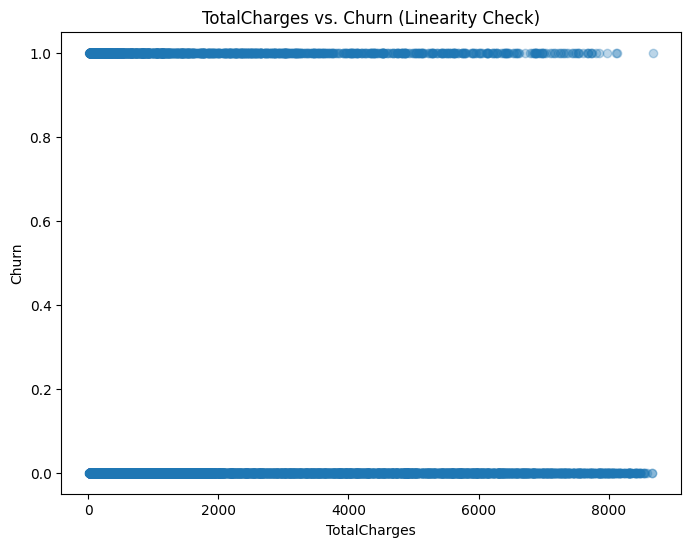

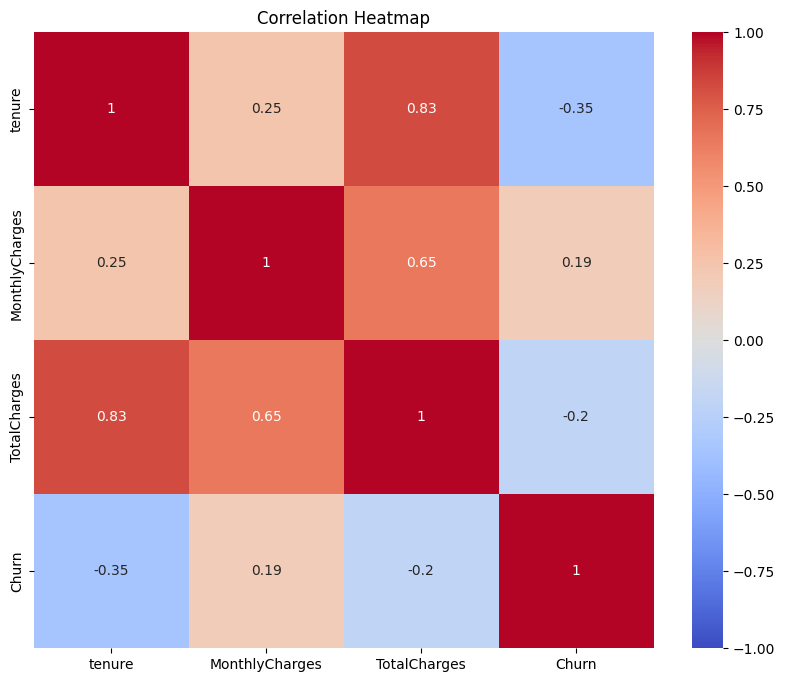

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                  Feature          VIF
11                     InternetService_No          inf
12     OnlineSecurity_No internet service          inf
20        StreamingTV_No internet service          inf
18        TechSupport_No internet service          inf
16   DeviceProtection_No internet service          inf
14       OnlineBackup_No internet service          inf
22    StreamingMovies_No internet service          inf
7                        PhoneService_Yes  1610.790977
2                          MonthlyCharges   802.929728
10            InternetService_Fiber optic   137.812496
8          MultipleLines_No phone service    54.666670
23                    StreamingMovies_Yes    22.500393
21                        StreamingTV_Yes    22.410836
3                            TotalCharges    10.817632
1                                  tenure     7.587550
9                       MultipleLines_Yes     6.878374
17                   DeviceProtection_Yes     6.515802
15        

In [10]:
## Exploratory Data Analysis to check Assumptions:

# Check Linearity
# Plot tenure vs Churn
plt.figure(figsize=(8, 6))
plt.scatter(df_encoded['tenure'], df_encoded['Churn'], alpha=0.3)
plt.title('Tenure vs. Churn (Linearity Check)')
plt.xlabel('Tenure')
plt.ylabel('Churn')
plt.show()

# Plot MonthlyCharges vs Churn
plt.figure(figsize=(8, 6))
plt.scatter(df_encoded['MonthlyCharges'], df_encoded['Churn'], alpha=0.3)
plt.title('MonthlyCharges vs. Churn (Linearity Check)')
plt.xlabel('MonthlyCharges')
plt.ylabel('Churn')
plt.show()

# Plot TotalCharges vs Churn
plt.figure(figsize=(8, 6))
plt.scatter(df_encoded['TotalCharges'], df_encoded['Churn'], alpha=0.3)
plt.title('TotalCharges vs. Churn (Linearity Check)')
plt.xlabel('TotalCharges')
plt.ylabel('Churn')
plt.show()

# Correlation Heatmap (Key Numeric Features and Churn)
plt.figure(figsize=(10, 8))
correlation_matrix = df_encoded[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# VIF (Variance Inflation Factor)
X = df_encoded.drop(columns=['Churn'])
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

Variance Inflation Factor (VIF) Table: Features like InternetService_No, OnlineSecurity_No internet service, and others show inf (infinite) VIF values, indicating perfect or near-perfect multicollinearity. This is likely due to the mutually exclusive nature of these features (e.g., if a customer has no internet, they can't have certain services).
PhoneService_Yes and MonthlyCharges also have extremely high VIF values, indicating multicollinearity.

In [12]:
# Target variable (Churn)
y = df_encoded['Churn']

# Ensure 'Churn' is excluded from the feature set
X = df_encoded.drop(columns=['Churn'])

# Define feature names (after excluding 'Churn')
feature_names = X.columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (important for regression models like Ridge and Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the shapes for debugging purposes
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Number of feature names: {len(feature_names)}")

Shape of X_train_scaled: (5625, 30)
Number of feature names: 30


In [13]:
# Function to fit and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, feature_names):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_train.shape[1] - 1)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Adjusted R2 Score: {adj_r2:.4f}")

    # Display top 10 coefficients for interpretability
    coef = pd.Series(model.coef_, index=feature_names)  # Ensure correct feature names are used
    print("Top 10 Coefficients:")
    print(coef.sort_values(key=abs, ascending=False)[:10])

    return model, y_pred

In [14]:
# Linear Regression Model
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression", feature_names)
# Ridge Regression Model
ridge_model, ridge_pred = evaluate_model(Ridge(alpha=1.0), X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression", feature_names)
# Lasso Regression Model
lasso_model, lasso_pred = evaluate_model(Lasso(alpha=0.1), X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression", feature_names)


Linear Regression:
MSE: 0.1459
R2 Score: 0.2524
Adjusted R2 Score: 0.2361
Top 10 Coefficients:
InternetService_Fiber optic       0.113458
TotalCharges                     -0.103233
MonthlyCharges                   -0.056418
Contract_One year                -0.047689
tenure                           -0.046151
StreamingMovies_Yes               0.037734
StreamingTV_Yes                   0.036125
Contract_Two year                -0.031810
PaymentMethod_Electronic check    0.029480
MultipleLines_Yes                 0.029346
dtype: float64

Ridge Regression:
MSE: 0.1459
R2 Score: 0.2525
Adjusted R2 Score: 0.2362
Top 10 Coefficients:
InternetService_Fiber optic       0.107515
TotalCharges                     -0.103137
Contract_One year                -0.047685
tenure                           -0.046196
MonthlyCharges                   -0.042060
StreamingMovies_Yes               0.035407
StreamingTV_Yes                   0.033805
Contract_Two year                -0.031796
PaymentMethod_Electr

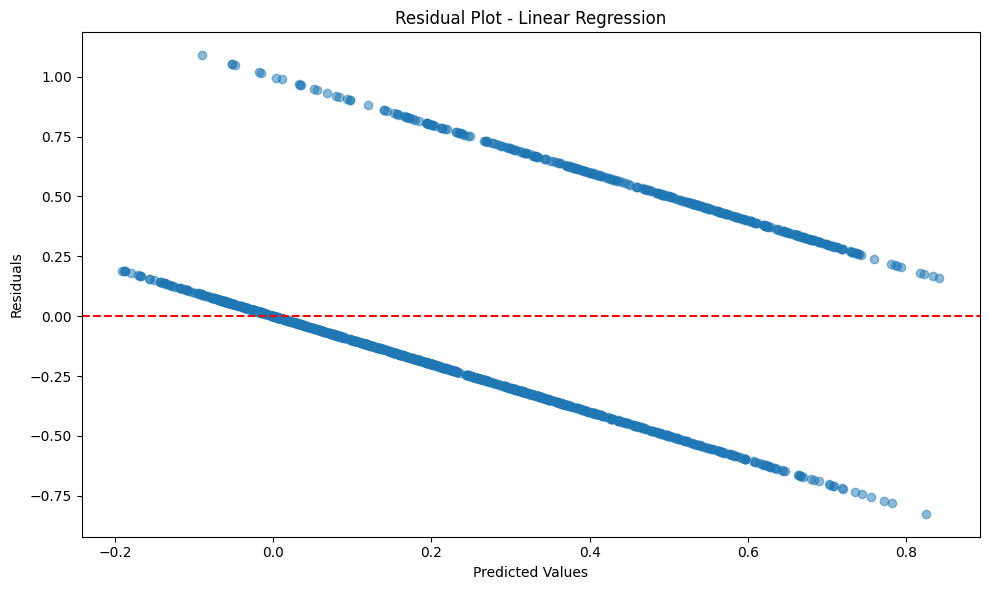

In [15]:
# Residual Plot
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))

    # Scatter plot with transparency
    plt.scatter(y_pred, residuals, alpha=0.5)

    # Labels and title
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')

    # Horizontal line at residual = 0
    plt.axhline(y=0, color='r', linestyle='--')

    plt.tight_layout()
    plt.show()

# Ensure y_test is compatible with y_pred (convert to numpy if needed)
plot_residuals(y_test, lr_pred, 'Linear Regression')

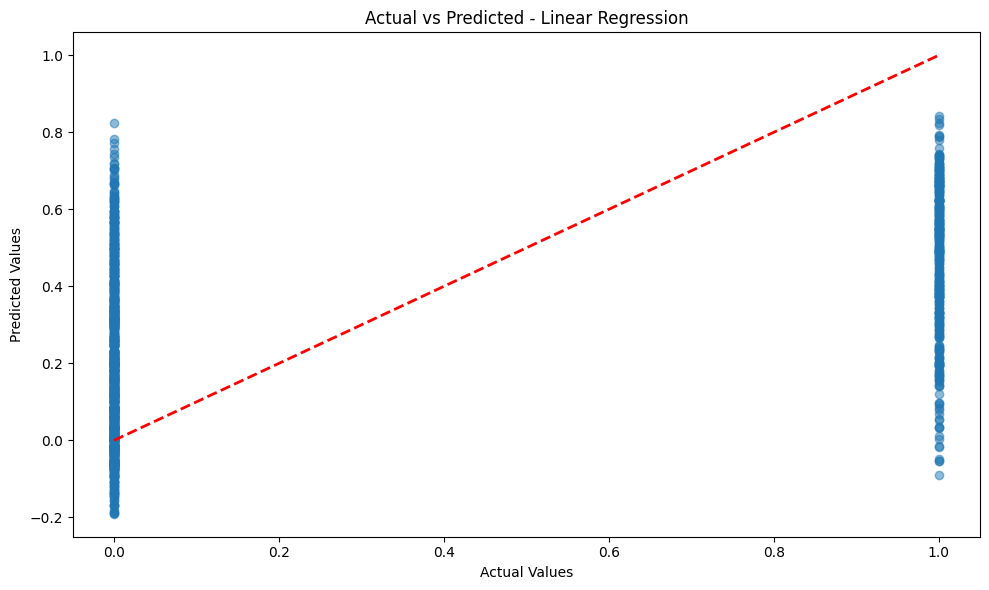

In [16]:
# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, lr_pred, 'Linear Regression')

In [17]:
#Check for autocorrelation
# Residuals for the linear regression model
lr_residuals = y_test - lr_pred

# Calculate DW statistic
dw_statistic = durbin_watson(lr_residuals)

print(f'Durbin-Watson statistic for Linear Regression: {dw_statistic:.4f}')

Durbin-Watson statistic for Linear Regression: 2.0013


DW test indicates nearly no autocorrelation

Losgistic Regression

Assumptions:
1. Binary or Dichotomous Dependent Variable: Met as Churn is binary
2. Independence of Observations
3. Linearity of Independent Variables and log odds, violated as certain continous variables failed to show linearity from BT test.
4. No Multicollinearity: VIF computation above indicates the data has Multicollinearity, excluded the one with high multicollinearity


In [25]:
# Remove 'Churn' column from df_encoded before proceeding (it should be in y)
X = df_encoded.drop(columns=['Churn', 'customerID'], errors='ignore')
y = df_encoded['Churn']
# Add a constant (intercept) to the model
X = add_constant(X)

In [27]:
# Recompute VIF to check for multicollinearity
X_no_const = X.drop(columns=['const'], errors='ignore')  # Exclude the constant term for VIF calculation
vif_data = pd.DataFrame()
vif_data['Feature'] = X_no_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_no_const.values, i) for i in range(X_no_const.shape[1])]

# Display VIF values
print(vif_data.sort_values(by="VIF", ascending=False))

# Drop features with VIF greater than a threshold (say, VIF > 10 indicates high multicollinearity)
high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
print(f"Features with high VIF: {high_vif_features}")

# Drop high VIF features
X_reduced = X_no_const.drop(columns=high_vif_features, errors='ignore')

# Add the constant back to the reduced feature set
X_reduced = add_constant(X_reduced)

# Box-Tidwell Test (Linearity Assumption) for continuous variables
continuous_features = ['tenure']  # Select continuous variables
X_reduced[continuous_features] = X_reduced[continuous_features].replace(0, 0.0001)

# Create interaction terms (X * log(X)) for each continuous variable
for feature in continuous_features:
    X_reduced[feature + '_log'] = X_reduced[feature] * np.log(X_reduced[feature])

# Fit the logistic regression model with interaction terms for Box-Tidwell test
logit_model_bt = sm.Logit(y, X_reduced)
result_bt = logit_model_bt.fit()

print("\nBox-Tidwell Test Results:")
print(result_bt.summary())

# Split the data into training and testing sets


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                  Feature          VIF
11                     InternetService_No          inf
12     OnlineSecurity_No internet service          inf
20        StreamingTV_No internet service          inf
18        TechSupport_No internet service          inf
16   DeviceProtection_No internet service          inf
14       OnlineBackup_No internet service          inf
22    StreamingMovies_No internet service          inf
7                        PhoneService_Yes  1610.790977
2                          MonthlyCharges   802.929728
10            InternetService_Fiber optic   137.812496
8          MultipleLines_No phone service    54.666670
23                    StreamingMovies_Yes    22.500393
21                        StreamingTV_Yes    22.410836
3                            TotalCharges    10.817632
1                                  tenure     7.587550
9                       MultipleLines_Yes     6.878374
17                   DeviceProtection_Yes     6.515802
15        

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Fit logistic regression model on training data
logit_model_final = sm.Logit(y_train, X_train)
result_final = logit_model_final.fit()

# Make predictions on test data
y_pred_prob = result_final.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Optimization terminated successfully.
         Current function value: 0.429115
         Iterations 8

Confusion Matrix:
[[936  97]
 [203 171]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.64      0.46      0.53       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.77      1407



Only tenure as continuous variable is left for BT test after VIF, however, tenure_log failed the assumption by bring zero p value.

**Accuracy:**

The overall accuracy of the model is 79%, indicating that 79% of the total predictions (both churn and non-churn) are correct.

**Precision, Recall, and F1-Score:**

For non-churn customers (class 0), the precision (0.82), recall (0.91), and F1-score (0.86) suggest that the model performs well at predicting customers who will stay. It correctly identifies 91% of non-churn customers, meaning it captures most of the loyal customers.

For churn customers (class 1), the precision (0.64), recall (0.46), and F1-score (0.53) indicate that the model struggles more with identifying customers who are at risk of churning. The model is identifying 64% of the predicted churn customers correctly, but it only captures 46% of the actual churn customers.

**Understanding the factors contributing to customer churn:**

Key factors influencing churn based on the logistic regression results include contract type, tenure, tech support, and payment method:

Longer contracts (one-year or two-year contracts) and longer tenure significantly reduce the likelihood of churn.
Customers who do not have tech support or other services like device protection or online security are more likely to churn.
The payment method also plays a role: those using electronic checks show a higher likelihood of churning.

**The type of customers who tend to churn or are at higher risk of churning:**

Customers with shorter contract durations are at a much higher risk of churning compared to those with longer contracts. Additionally, customers without tech support, online security, or device protection are more prone to leaving. Those who pay using electronic checks also show a higher risk of churn, suggesting this payment method could be associated with less satisfied customers. Finally, newer customers with shorter tenure are also at a greater risk of leaving.

The logistic regression model performed reasonably well in predicting customer churn, as indicated by the Pseudo R-squared of 0.2554, meaning the model explains approximately 25.54% of the variance in the churn outcome. Several features, such as SeniorCitizen, tenure, MultipleLines_Yes, and Contract_Two year, were statistically significant, indicating they strongly influence churn behavior. However, the Box-Tidwell test revealed that the linearity assumption between tenure and the log-odds of churn was violated, suggesting that the relationship between tenure and churn is non-linear. Despite this, the model successfully identified key drivers of churn but could potentially benefit from addressing the non-linearity and multicollinearity to improve its predictive accuracy.

In [ ]:
## GAM

Assumptions:
1. Independence of Observation: met as customer data should be independent with no repeated measures for the same customer
2. Multicolineatiy: met as high VIF factors excluded
3. Homoscedasticity: not met as residual plot is not funel like
4. Large sample size: met as the dataset has over 7000 observations


In [32]:
df_encoded.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [42]:
# Dropping high VIF features from df_encoded
high_vif_features = ['MonthlyCharges', 'TotalCharges', 'PhoneService_Yes', 'MultipleLines_No phone service',
                     'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service',
                     'OnlineBackup_No internet service', 'DeviceProtection_No internet service',
                     'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingTV_Yes',
                     'StreamingMovies_No internet service', 'StreamingMovies_Yes']

# Dropping high VIF features from df_encoded
df_reduced = df_encoded.drop(columns=high_vif_features, errors='ignore')

# Display the remaining features
print(df_reduced.columns)


Index(['SeniorCitizen', 'tenure', 'Churn', 'gender_Male', 'Partner_Yes',
       'Dependents_Yes', 'MultipleLines_Yes', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [45]:
# List of selected features
selected_features = ['SeniorCitizen', 'tenure', 'gender_Male', 'Partner_Yes',
                     'Dependents_Yes', 'MultipleLines_Yes', 'OnlineSecurity_Yes',
                     'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
                     'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
                     'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
                     'PaymentMethod_Mailed check']

In [46]:
# Use df_encoded to filter these features
X = df_encoded[selected_features]
y = df_encoded['Churn']  # Target variable

In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale only the numeric features (tenure)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled['tenure'] = scaler.fit_transform(X_train[['tenure']])
X_test_scaled = X_test.copy()
X_test_scaled['tenure'] = scaler.transform(X_test[['tenure']])

In [48]:
# Create the GAM model, treating 'tenure' as smooth term and others as factor terms
gam = LogisticGAM(
    s(1) +    # tenure (continuous)
    f(0) +    # SeniorCitizen (categorical)
    f(2) +    # gender_Male (categorical)
    f(3) +    # Partner_Yes (categorical)
    f(4) +    # Dependents_Yes (categorical)
    f(5) +    # MultipleLines_Yes (categorical)
    f(6) +    # OnlineSecurity_Yes (categorical)
    f(7) +    # OnlineBackup_Yes (categorical)
    f(8) +    # DeviceProtection_Yes (categorical)
    f(9) +    # TechSupport_Yes (categorical)
    f(10) +   # Contract_One year (categorical)
    f(11) +   # Contract_Two year (categorical)
    f(12) +   # PaperlessBilling_Yes (categorical)
    f(13) +   # PaymentMethod_Credit card (automatic) (categorical)
    f(14) +   # PaymentMethod_Electronic check (categorical)
    f(15)     # PaymentMethod_Mailed check (categorical)
)

# Fit the GAM model on the training data
gam.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = gam.predict(X_test_scaled)

# Evaluate the model using confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output the evaluation results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[937  96]
 [197 177]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1033
           1       0.65      0.47      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



**Accuracy:**

The overall accuracy of the model is 79%, indicating that 79% of the total predictions (both churn and non-churn) are correct.

**Precision, Recall, and F1-Score:**

For non-churn customers (class 0), the precision (0.83), recall (0.91), and F1-score (0.86) suggest that the model is quite good at predicting customers who will stay. It correctly identifies 91% of non-churn customers, meaning it captures most of the customers who are loyal.

For churn customers (class 1), the model's precision (0.65), recall (0.47), and F1-score (0.55) are lower, indicating that the model has more difficulty identifying customers who are at risk of churning. The model is identifying 65% of the predicted churn customers correctly, but it only captures 47% of the actual churn customers.

**Understanding the factors contributing to customer churn:**

Key factors influencing churn include contract type, tenure, tech support, and payment method. Customers with longer contracts and tenure are less likely to churn, while those without tech support or using electronic check payments are more prone to leaving. This insight allows companies to focus on retaining customers by offering better support services or longer-term contract incentives.

**The type of customers tend to churn or are at higher risk of churning:**

Customers with shorter contract durations (like month-to-month contracts) are at a much higher risk of churning compared to those with longer contracts. Additionally, customers who do not have tech support, device protection, or online security are more likely to churn. Those who opt for electronic check payments also show a higher tendency to leave, indicating that this payment method may be associated with less loyal customers. Lastly, customers with lower tenure (newer customers) are at a higher risk of leaving the service.

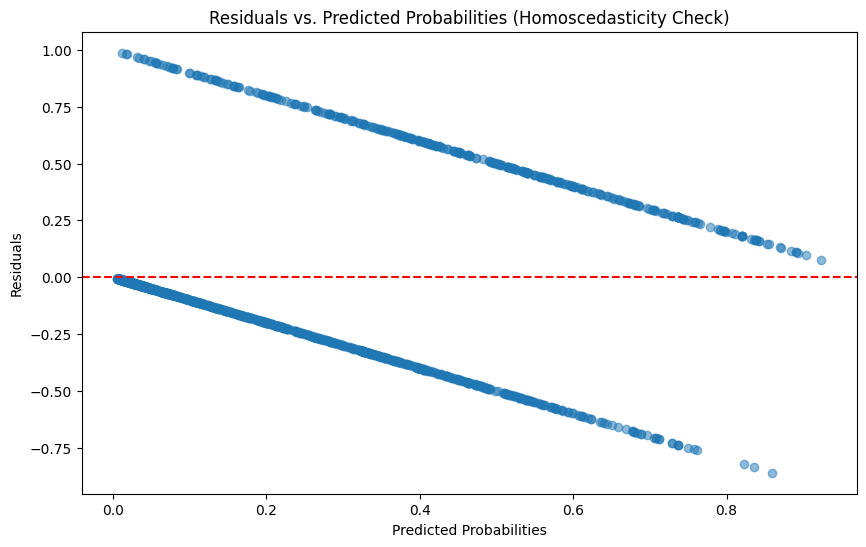

In [49]:
# Check for heteroscedasticity
# Get the predicted probabilities and residuals from the model
y_pred_prob = gam.predict_proba(X_test_scaled)  # Predicted probabilities
residuals = y_test - y_pred_prob  # Residuals (observed - predicted)

# Plot residuals vs. predicted probabilities
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_prob, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Predicted Probabilities')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Probabilities (Homoscedasticity Check)')
plt.show()

**Model Comparation:**

**Ridge Regression(selected as best overall linear regression model):**\
**Performance:**\
MSE: 0.1459\
R² Score: 0.2524\
Adjusted R² Score: 0.2361\
**Top Features:**\
Positive impact: InternetService_Fiber optic, StreamingMovies_Yes, StreamingTV_Yes, MultipleLines_Yes, PaymentMethod_Electronic check\
Negative impact: TotalCharges, Contract_One year, Contract_Two year, tenure, MonthlyCharges\
**Strength:**\
Easy to interpret, providing clear insights into the direction of relationships (positive or negative) between predictors and churn.\
Simple to implement and understand.\
**Weakness:**\
Low predictive performance, as seen in the low R² score, indicating that linear regression explains only around 23% of the variability in customer churn.\
Assumes a linear relationship between the independent variables and churn, which may not be the best assumption for this problem, especially with categorical variables.


**Logistic Regression:**\
**Performance:**\
Accuracy: 0.79\\
Precision (Churn Class 1): 0.64\
Recall (Churn Class 1): 0.47\
F1-Score (Churn Class 1): 0.55\
**Top Features:**\
Positive: MultipleLines_Yes, DeviceProtection_Yes, PaperlessBilling_Yes, PaymentMethod_Electronic check\
Negative: tenure, TechSupport_Yes, Contract_One year, Contract_Two year\
**Strengths:**\
Logistic regression is better suited for binary outcomes like churn (0 or 1), as it models the probability of churn directly.
More interpretable for categorical variables, providing odds ratios that can tell how much each factor increases/decreases the odds of churn.
Better at capturing non-linearities through the log-odds transformation.\
**Weaknesses:**\
Although more suitable for binary outcomes, the recall for predicting churn is still quite low at 47%, meaning it misses many actual churn cases.
Doesn’t handle highly non-linear relationships well.

**Generalized Additive Model (GAM):**\
**Performance:**\
Accuracy: 0.79\
Precision (Churn Class 1): 0.65\
Recall (Churn Class 1): 0.47\
F1-Score (Churn Class 1): 0.55\
**Strengths:**\
GAM offers greater flexibility by allowing non-linear relationships between predictors and churn. It can capture more complex patterns compared to logistic regression or linear regression.\
By modeling each predictor individually with smooth functions, GAM can provide insights into how each factor affects churn in a non-linear way.\
**Weaknesses:**\
Less interpretable compared to logistic regression and linear regression, especially in terms of understanding specific feature effects.\
The recall and F1 score are similar to logistic regression, meaning it still struggles to identify churn cases effectively.



**Recommandation for Telecommunications Company:**
Logistic Regression could be the recommended model for its interpretability and prediction for binary outcomes like churn. It provides analysis that tells factors influence customer churn. Although the recall and F1 scores are not perfect, logistic regression gives interpretable odds ratios for actionable business decisions.

In [52]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [54]:
%cd /content/drive/My Drive/assignment #03


/content/drive/My Drive/assignment #03


In [55]:
!git config --global user.name "Haodong12"
!git config --global user.email "yingmanyuetai@gmail.com"


In [56]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/drive/MyDrive/assignment #03/.git/


In [57]:
!git remote add origin https://github.com/Haodong12/AIPI-590.git

In [58]:
!git add .

In [59]:
!git commit -m "Added Colab notebook and folder files"

[master (root-commit) d261a3b] Added Colab notebook and folder files
 2 files changed, 7045 insertions(+)
 create mode 100644 Telco-Customer-Churn.csv
 create mode 100644 assignment3.ipynb


In [61]:
!git branch -M main

In [62]:
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [64]:
!git remote remove origin
!git remote add origin https://<TOKEN>@github.com/Haodong12/AIPI-590.git
!git push -u origin main


error: No such remote: 'origin'
/bin/bash: line 1: TOKEN: No such file or directory
fatal: 'origin' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
